# Running Back Performance Predictors: A Cluster Analysis
Andrea Wright

# Project setup

## Install packages

In [230]:
# uncomment the line below if you have never installed nfl_data_py or are encountering an error

In [231]:
pip install nfl_data_py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [232]:
### DO NOT UNCOMMENT THIS SECTION ###
# details regarding this package can be found here:
# https://pypi.org/project/nfl-data-py/

In [233]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import matplotlib.pyplot as plt

In [234]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [235]:
pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [236]:
from kneed import KneeLocator

In [237]:
In [1]: import matplotlib.pyplot as plt
   ...: from kneed import KneeLocator
   ...: from sklearn.datasets import make_blobs
   ...: 
   ...: 
   ...: 

In [238]:
!pip install kmodes
from kmodes.kmodes import KModes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download data

In [239]:
all_rbs = nfl.import_combine_data([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021], ['RB'])

In [240]:
top_rbs = pd.read_csv('TopRBs.csv')

In [241]:
# check data imported correctly
top_rbs.head()

,NAME
0,Derrick Henry*+
1,Dalvin Cook*
2,Jonathan Taylor
3,Aaron Jones*
4,David Montgomery


Note: There are unique cases where a quarterback is a top rusher in the NFL, even compared to running backs. Since the top 20 rushers were pulled, this may include quarterbacks in the `TopPerformers.csv` file. However, they are not included in the analysis. 

## Data Cleaning

### Drop columns not relevant to analysis. 

In [242]:
#test = test[test['draft_team'].notna()] # subset to include only those who were drafted
all_rbs.drop(['draft_round', 'draft_team', 'pos', 'school', 'draft_ovr', 'pfr_id', 'cfb_id', 'season'], axis=1, inplace=True)

### Format variable, `height`

The format of the variable height, `ht`, is indecipherable to an algorithm. Convert it to a decimal below. 

In [243]:
# convert current column from object to string
all_rbs=all_rbs.astype({'ht':'string'})

In [244]:
# split string on the '-' that separates feet from inches
all_rbs[['ht_ft', 'ht_in']] = all_rbs['ht'].str.split("-",expand=True)

In [245]:
# convert separated columns into numeric values (they are currently strings)
all_rbs['ht_ft'] = pd.to_numeric(all_rbs['ht_ft'],errors='coerce')
all_rbs['ht_in'] = pd.to_numeric(all_rbs['ht_in'],errors='coerce')

In [246]:
# get inches into decimal form 
all_rbs['ht_in'] = all_rbs['ht_in'] / 12

In [247]:
# re-assign height column to new decimals
all_rbs['ht'] = all_rbs['ht_ft'] + all_rbs['ht_in']
# drop separate ft and inches columns
all_rbs.drop(['ht_ft', 'ht_in'],axis=1,inplace=True)

### Find top-performers draft measurements

Cross reference top performing running backs, `top_rbs` with their combine stats from `all_rbs` and save this in its own dataframe, `top_rbs_combine`. 

In [248]:
top_rbs_combine = all_rbs[all_rbs["player_name"].isin(top_rbs['NAME'])]

In [249]:
top_rbs_combine.drop('draft_year', axis=1, inplace=True)

<ipython-input-249-66a4e7fb655e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_rbs_combine.drop('draft_year', axis=1, inplace=True)


In [250]:
top_rbs_combine.head()

,player_name,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle
1,Shaun Alexander,6.000000,218.0,4.58,NaN,NaN,NaN,NaN,NaN
76,Ron Dayne,5.916667,259.0,4.65,NaN,NaN,NaN,NaN,NaN
80,Reuben Droughns,5.916667,215.0,4.66,13.0,30.0,115.0,7.34,4.41
124,Troy Hambrick,6.000000,237.0,4.66,21.0,34.5,118.0,7.48,4.44
165,Thomas Jones,5.833333,216.0,4.45,NaN,NaN,NaN,NaN,NaN


# Select Players

## Select two 2021 draft players

In [251]:
rb_draft = all_rbs[all_rbs.draft_year == 2021]
rb_draft.drop(['draft_year', 'ht', 'bench', 'vertical', 'broad_jump', 'shuttle'], axis=1, inplace=True)
rb_draft.dropna(inplace=True)

<ipython-input-251-120b7da2b586>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb_draft.drop(['draft_year', 'ht', 'bench', 'vertical', 'broad_jump', 'shuttle'], axis=1, inplace=True)
<ipython-input-251-120b7da2b586>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb_draft.dropna(inplace=True)


In [252]:
draft_predictors = rb_draft.sample(n=5, random_state = 1)
draft_predictors

,player_name,wt,forty,cone
7010,Chris Evans,211.0,4.50,6.83
7030,Jake Funk,204.0,4.49,6.71
7064,Khalil Herbert,210.0,4.46,6.96
7273,Rhamondre Stevenson,231.0,4.64,7.09
6955,Michael Carter,201.0,4.50,6.81


# Data Analysis


## Top performers: what groups (clusters) do they generate?

### Set up clustering

From literature (see associated paper), we know that for running backs, the forty-yard dash (`forty`), weight (`wt`), and the 3-cone drill (`cone`) are the most important predictors of performance. For this analysis, we will group players based on these three drills. 

In [253]:
predictors = top_rbs_combine[['forty', 'wt', 'cone']]

It is not required that athletes compete in all aspects of the NFL Combine. In the following line, we drop observations (athletes) who did not complete all three drills (forty-yard dash, weight, cone). 

In [254]:
predictors.dropna(inplace=True)

<ipython-input-254-afd677adf460>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors.dropna(inplace=True)


In [255]:
predictors.shape

(76, 3)

### Evaluate the 'elbow'

To determine the optimal number of clusters, k, that should be used to divide this data, we evaluate a the number of clusters versus the 'Cost', which is an indicator of distortion between the clusters. 

In [256]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# get SSE for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(predictors)
  sse.append(kmeans.inertia_)

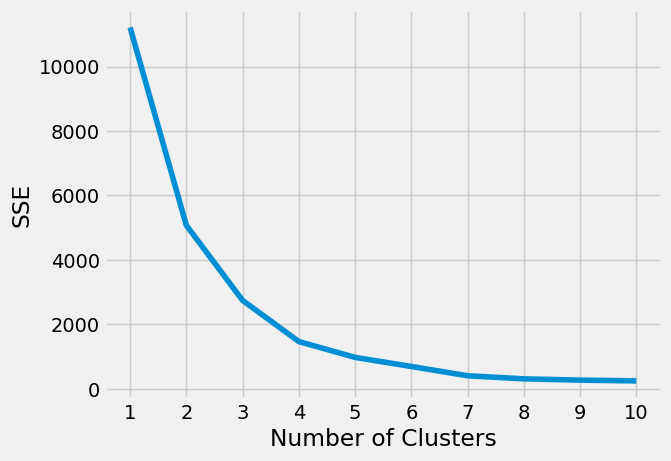

In [257]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [258]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
optimal_clusters = kl.elbow
print(f'The optimal number of clusters is {optimal_clusters}')

The optimal number of clusters is 4


### Generate clusters

In [259]:
# build model with cluster number from above
kmeans_init = KMeans(n_clusters=optimal_clusters, random_state=1)
clusters = kmeans_init.fit_predict(predictors[['forty', 'wt', 'cone']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [260]:
predictors['Cluster'] = clusters

<ipython-input-260-26f1287a5472>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors['Cluster'] = clusters


In [261]:
predictors.head()

,forty,wt,cone,Cluster
80,4.66,215.0,7.34,1
124,4.66,237.0,7.48,3
476,4.57,227.0,7.32,3
606,4.58,229.0,7.48,3
607,4.46,221.0,6.84,1


How many players exist in each cluster?

In [262]:
predictors.Cluster.value_counts(ascending=True)

2     3
0    16
3    22
1    35
Name: Cluster, dtype: int64

Get centers of clusters - what defines each group?

In [263]:
cluster_centers = kmeans_init.cluster_centers_

In [264]:
cluster_names = ['0', '1', '2', '3']
cluster_centers_visual = pd.DataFrame(cluster_centers, columns = ['forty','wt','cone'])
cluster_centers_visual = cluster_centers_visual.assign(ClusterNumber=cluster_names)
cluster_centers_visual

,forty,wt,cone,ClusterNumber
0,4.516875,202.375000,6.903750,0
1,4.520000,216.542857,7.014286,1
2,4.600000,251.666667,7.193333,2
3,4.571818,228.409091,7.116818,3


The Table 1 below describes the three clusters. 

**Table 1. Unique cluster attributes**

|Cluster Number|Cluster Name|Forty-Yard Dash Time [s]|Weight [lbs]|Cone Drill Time [s]|
|:--------:|-----------|:----:|:----:|:----:|
|0|Dual Threat|4.52|202.4|6.90|
|1|Rugged RBs|4.52|216.5|7.01|
|2|Power Players|4.60|251.7|7.19|
|3|Mid-Range RBs|4.57|228.4|7.12|



* **Cluster 0, Dual Threat**. These athletes are distinguished by their speed in both the forty-yard dash (a powerful, forward momvement examination) and speed + agility in the cone drill. 

* **Cluster 1., Rugged RBs** Mid-range in weight, these athletes have the fastest forty-yard dash time of all clusters and cone drill times that rival Cluster 0, Dual Threat. However, they are about 14 pounds heavier than Cluster 0, suggesting increased lean body mass. 

* **Cluster 2, Power Players** These athletes are the heaviest of all clusters and posses decent forty-yard speeds. They are lacking in agility. 

* **Cluster 3, Mid-Range RBs** These athletes rank in the middle for all categories. 

## Draft Picks: Which clusters do they fall into?

Next, evaluate into which cluster the randomly selected draft picks will fall. 

In [265]:
draft_predictors

,player_name,wt,forty,cone
7010,Chris Evans,211.0,4.50,6.83
7030,Jake Funk,204.0,4.49,6.71
7064,Khalil Herbert,210.0,4.46,6.96
7273,Rhamondre Stevenson,231.0,4.64,7.09
6955,Michael Carter,201.0,4.50,6.81


In [266]:
new_players_cluster = kmeans_init.predict(draft_predictors[['forty', 'wt', 'cone']])

In [267]:
draft_predictors['Cluster'] = new_players_cluster

The table below describes each player from the 2021 selected and the cluster they fell into. 

In [268]:
draft_predictors

,player_name,wt,forty,cone,Cluster
7010,Chris Evans,211.0,4.50,6.83,1
7030,Jake Funk,204.0,4.49,6.71,0
7064,Khalil Herbert,210.0,4.46,6.96,1
7273,Rhamondre Stevenson,231.0,4.64,7.09,3
6955,Michael Carter,201.0,4.50,6.81,0
